# CS771 HomeWork Assignment 2

### Imporing Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.metrics import accuracy_score

In [2]:
#improting required libraires for plotting the graphs

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
from sklearn.metrics.pairwise import rbf_kernel

### Ignoring Warning for cleaner look

In [5]:
### Ye bas final ke liye run karna kuch erro find karna ho  to run mat karna 
import warnings
warnings.filterwarnings("ignore")


### Resnet50 for feature extraction

In [ ]:
model = models.resnet50(pretrained=True)

model.fc = torch.nn.Identity()  # Remove last layer for feature extraction

model.eval()

### Use GPU if avaliable

In [9]:
# switch the device to cuda avaliabel for faster computations 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Image Transformation

In [10]:
# Define the transformation (resize, normalize, etc.)
# Transform the image as required by the resnet50 model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Loss Function

##### Might use ahead if required

In [33]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        smooth_label = self.smoothing / pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        log_probs = pred.log_softmax(dim=-1)
        return -(confidence * one_hot + smooth_label).mul(log_probs).sum(dim=1).mean()

### Loading dataset

In [32]:
def load_data(path):
    data = torch.load(path, weights_only=False)
    images = data.get('data')
    if images is None:
        raise ValueError(f"'data' key is missing or None in file: {path}")

    labels = data.get('targets')
    if labels is None:
        labels = None

    features = torch.tensor(images / 255.0, dtype=torch.float32).contiguous()
    if labels is not None:
        labels = torch.tensor(labels, dtype=torch.long)
    return features, labels

### Extract Features

In [11]:
# Feature extraction function
def extract_features(images):
    features = []
    with torch.no_grad():
        for img in images:
            img_tensor = transform(img).unsqueeze(0)
            feat = model(img_tensor).view(1, -1)  # Flatten to 1D
            features.append(feat.numpy())
    return np.concatenate(features)

In [12]:
heldout_features = {}

In [13]:
# Extract and store features only once for each heldout dataset
def get_or_extract_features(dataset_name, dataset_data):
    if dataset_name not in heldout_features:
        heldout_features[dataset_name] = extract_features(dataset_data)
    return heldout_features[dataset_name]

### Compute Class Protoype

In [14]:
# Compute class prototypes
# For doing lwp compute the class prototype for each class
def compute_prototypes(features, labels):
    prototypes = {}
    for label in np.unique(labels):
        prototypes[label] = features[labels == label].mean(axis=0)
    return prototypes

In [15]:
# Contrastive alignment
def prototype_contrastive_alignment(prev_prototypes, curr_prototypes, alpha=0.5):
    aligned_prototypes = {}
    for cls in curr_prototypes.keys():
        if cls in prev_prototypes:
            aligned_prototypes[cls] = alpha * prev_prototypes[cls] + (1 - alpha) * curr_prototypes[cls]
        else:
            aligned_prototypes[cls] = curr_prototypes[cls]
    return aligned_prototypes

### Prediction using Cosine Similarity

In [16]:
# Predict with Cosine Similarity
def cosine_pseudo_labels(features, prototypes):
    predictions, confidences = [], []

    # Prepare prototypes as a matrix for vectorized computation
    proto_matrix = np.array(list(prototypes.values()))
    proto_labels = list(prototypes.keys())

    # Normalize prototypes for cosine similarity
    proto_norms = np.linalg.norm(proto_matrix, axis=1, keepdims=True)
    normalized_prototypes = proto_matrix / proto_norms

    for feature in features:
        # Normalize the feature
        feature_norm = np.linalg.norm(feature)
        normalized_feature = feature / feature_norm

        # Compute cosine similarity with all prototypes
        similarities = normalized_prototypes @ normalized_feature

        # Get the top class with highest similarity
        sorted_indices = np.argsort(similarities)[::-1]
        top_class = proto_labels[sorted_indices[0]]
        top_sim = similarities[sorted_indices[0]]
        second_sim = similarities[sorted_indices[1]]

        # Confidence is the ratio of top two similarities
        confidence = second_sim / top_sim if top_sim != 0 else 0

        predictions.append(top_class)
        confidences.append(confidence)

    return np.array(predictions), np.array(confidences)

In [17]:
# Initialize variables
performance_matrix = np.zeros((20, 20))
prev_prototypes = None

### NN Classifier (may use if running on cuda)

In [34]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

### Building the f1 model

In [18]:
# Loading the first dataset for building the f11 mdel

train1 = torch.load('../dataset/dataset/part_one_dataset/train_data/1_train_data.tar.pth')
train1_images = train1['data']
train1_labels = train1['targets']

train1_features = extract_features(train1_images)
prototype1 = compute_prototypes(train1_features, train1_labels)

prev_prototypes = prototype1


test1 = torch.load('../dataset/dataset/part_one_dataset/eval_data/1_eval_data.tar.pth')
test1_images = test1['data']
test1_labels = test1['targets']

test1_features = get_or_extract_features("D1", test1_images)
predictions, _ = cosine_pseudo_labels(test1_features, prototype1)
accuracy = accuracy_score(test1_labels, predictions)

In [19]:
performance_matrix[0][0] = accuracy*100

In [20]:
accuracy

0.7992

### Training , Predicting and building Models for Task-1

In [24]:
# Update loop for D2 to D10
for i in range(2, 11):
    # Load and extract features
    train = torch.load(f'../dataset/dataset/part_one_dataset/train_data/{i}_train_data.tar.pth')
    train_images = train['data']
    features = extract_features(train_images)

    # Predict pseudo-labels using cosine similarity
    pseudo_labels, confidences = cosine_pseudo_labels(features, prev_prototypes)

    # Filter by confidence threshold
    reliable_indices = confidences > 0.5  # Confidence threshold
    reliable_features = features[reliable_indices]
    reliable_labels = pseudo_labels[reliable_indices]

    # Compute and align prototypes
    prototypes = compute_prototypes(reliable_features, reliable_labels)
    prototypes = prototype_contrastive_alignment(prev_prototypes, prototypes)

    # Evaluate on held-out datasets
    for j in range(1, i + 1):
        
        test = torch.load(f'../dataset/dataset/part_one_dataset/eval_data/{j}_eval_data.tar.pth')

        test_images = test['data']
        test_labels = test['targets']
        test_features = get_or_extract_features(f'D{j}', test_images)

        predictions, _ = cosine_pseudo_labels(test_features, prototypes)
        accuracy = accuracy_score(test_labels, predictions)
        print(accuracy)
        performance_matrix[i-1, j-1] = accuracy*100

    prev_prototypes = prototypes

0.7776
0.7892
0.77
0.7884
0.7784
0.7656
0.7792
0.774
0.7764
0.7596
0.7736
0.7688
0.7708
0.7708
0.754
0.7676
0.7612
0.7676
0.7708
0.7628
0.754
0.7688
0.7584
0.7652
0.7692
0.758
0.7556
0.748
0.76
0.76
0.7628
0.7636
0.7536
0.7524
0.7532
0.7476
0.7616
0.7604
0.7604
0.7592
0.7548
0.7492
0.752
0.7344
0.7432
0.7588
0.756
0.7596
0.7556
0.7528
0.7488
0.75
0.732
0.7688


### Printing the accuracy matrix for the task1

In [26]:
print(performance_matrix)

[[79.92  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [77.76 78.92  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [77.   78.84 77.84  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [76.56 77.92 77.4  77.64  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [75.96 77.36 76.88 77.08 77.08  0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [75.4  76.76 76.12 76.76 77.08 76.28  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [75.4  76.88 75.84 76.52 76.92 75.8  75.56  0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [74.8  76.   76.   76.28 76.36 75.36 75.24 75.32  0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [74.76 76.16 76

### Plotting the results

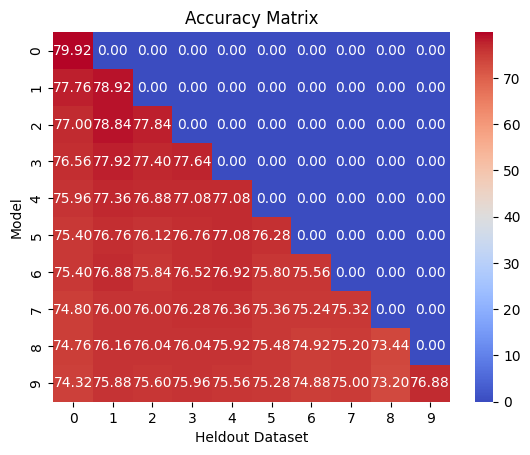

In [28]:
# Slice the matrix to get the top left 10x10 part
accuracy_matrix_10x10 = performance_matrix[:10, :10]

# Plot Accuracy Matrix
sns.heatmap(accuracy_matrix_10x10, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Accuracy Matrix")
plt.xlabel("Heldout Dataset")
plt.ylabel("Model")
plt.show()